In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression


### Correlation Between attendance and the exam being online
It was an educated guess, as you can see there is a correlation but one that can be omitted by removing some of the absolute worst of the online exams

In [2]:
# placeholder = pd.read_csv("data_description.csv")
# print("Before: " , placeholder['isOnline'].corr(placeholder['count']))
# placeholder = placeholder[~placeholder['ExamFieldID'].isin({1736,1844,1850})]
# print("After: " , placeholder['isOnline'].corr(placeholder['count']))

Therefore:

In [85]:
df = pd.read_csv("/Users/arminnoqteh/PlaceHolder/G2 Projects/PerformanceProject/STDINFO/Data-Table 1.csv")

df = df.drop(columns=['RotbehInGlobal','StudentGrade','StudentTaraz','PublicLessonsGrade','PublicLessonsTaraz'])
df = df[~df['ExamFieldID'].isin({1736,1844,1850})].rename(columns={'PrivateLessonsTaraz':'Taraz','PrivateLessonsGrade':'Score','ExamFieldID':'ExamID'})

In [86]:
# Remove students who attended only once
df = df.groupby('UserID').filter(lambda x: len(x) > 1)

# Group the data by user and score category
grouped = df.groupby(['UserID'])['Taraz'].mean()

In [87]:
# Calculate the attendance rate for each student
attendance = df.groupby('UserID')['ExamID'].nunique() / df['ExamID'].nunique()

# Categorize students based on their average score
labels = ['Poor', 'Below Average', 'Average', 'Above Average', 'Excellent']
grouped_categories = pd.qcut(grouped, 5, labels=labels)

# Add the attendance rate to the categorized data
grouped_categories = pd.concat([grouped_categories, attendance], axis=1)
grouped_categories.columns = ['Score Category', 'Attendance Rate']

In [88]:
from scipy.stats import linregress

# Calculate the linear regression for each score category
regressions = {}
for category in labels:
    x = df[df['Score Category'] == category]['ExamID']
    y = df[df['Score Category'] == category]['Score']
    slope, intercept, _, _, _ = linregress(x, y)
    regressions[category] = (slope, intercept)

KeyError: 'Score Category'

In [67]:
# Compute the number of exams attended by each student
num_exams_attended = df.groupby('UserID')['ExamID'].nunique()

# Compute the minimum number of exams attended for inclusion in the analysis
min_num_exams = int(np.ceil(0.5 * num_exams_attended.max()))

# Filter the data to include only students who attended at least min_num_exams
df = df[df['UserID'].isin(num_exams_attended[num_exams_attended >= min_num_exams].index)]

# create a new variable to represent the order of the exams
df['ExamOrder'] = df.groupby('ExamID')['ExamID'].rank(ascending=False)

# Group the data by student ID and calculate the average score for each student
grouped = df.groupby('UserID')['Taraz'].mean()

# Label the quantiles
labels = ['Low', 'Medium', 'High']
grouped_categories = pd.qcut(grouped, 3, labels=labels)

# Create a DataFrame that maps each student ID to their score category
student_categories = pd.DataFrame({'Taraz Category': grouped_categories})
student_categories.index.name = 'UserID'

# Merge the score categories back into the original DataFrame
df = df.merge(student_categories, on='UserID')

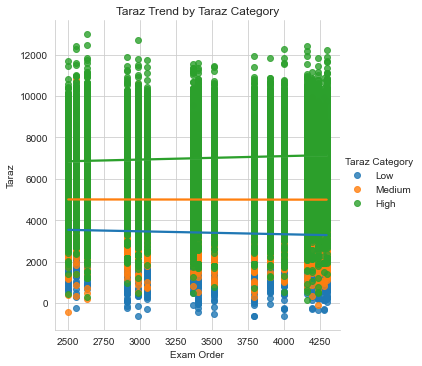

In [64]:
# plot the scores by exam order and score category
sns.lmplot(x='ExamOrder', y='Taraz', hue='Taraz Category', data=df)

# set the plot title and axis labels
plt.title('Taraz Trend by Taraz Category')
plt.xlabel('Exam Order')
plt.ylabel('Taraz')

# save the plot
plt.savefig('taraz_trend.png')

In [68]:
# Group the data by exam and score category and compute the mean score for each group
exam_scores = df.groupby(['ExamID', 'Taraz Category'])['Taraz'].mean().reset_index()

# Pivot the data to create a table with the score categories as columns and the exams as rows
pivoted_scores = exam_scores.pivot(index='ExamID', columns='Taraz Category', values='Taraz')


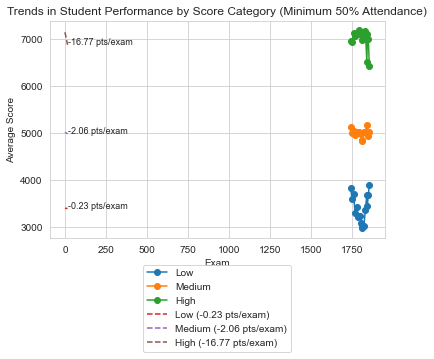

In [69]:
# Plot the data as a line chart
ax = pivoted_scores.plot(kind='line', marker='o')
ax.set(xlabel='Exam', ylabel='Average Score', title='Trends in Student Performance by Score Category (Minimum 50% Attendance)')

# Add linear regression lines and slope annotations for each score category
for col in pivoted_scores.columns:
    x = np.array(range(len(pivoted_scores)))
    y = pivoted_scores[col]
    mask = ~np.isnan(y)
    if sum(mask) > 1:
        lr = LinearRegression()
        lr.fit(x[mask].reshape(-1, 1), y[mask].values.reshape(-1, 1))
        slope = lr.coef_[0][0]
        ax.plot(x, lr.predict(x.reshape(-1, 1)), label=f'{col} ({slope:.2f} pts/exam)', linestyle='--')
        ax.text(x[-1]+0.5, lr.predict(np.array([x[-1]]).reshape(-1, 1))[0,0], f'{slope:.2f} pts/exam', fontsize=9)

# Move the legend to the upper left corner of the plot

# set the legend position and save the figure
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.savefig("QueCeQueC'est?.pdf", bbox_inches='tight')

In [ ]:
# plot the data using box plot
fig, ax = plt.subplots()
ax.boxplot([df[df['Taraz Category']=='Below Average']['Score'], df[df['Score Category']=='Average']['Score'], df[df['Above Average']=='High']['Score']])
ax.set_xticklabels(['Low', 'Medium', 'High'])

# set the plot title and axis labels
ax.set_title('Score Distribution by Score Category')
ax.set_xlabel('Score Category')
ax.set_ylabel('Score')

# save the plot
plt.savefig('score_distribution.png')


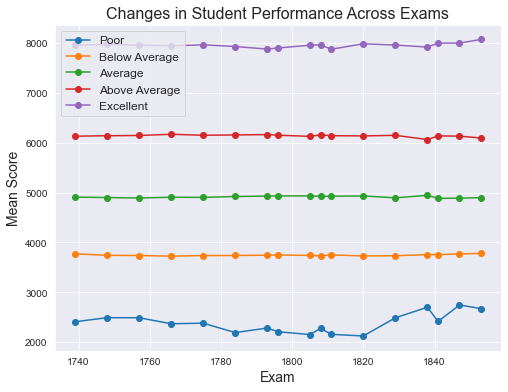

In [17]:
# Plot a line chart of the mean score for each category in each exam
ax = table.plot(kind='line', figsize=(8, 6), marker='o')

# Set the chart title and axis labels
ax.set_title('Changes in Student Performance Across Exams', fontsize=16)
ax.set_xlabel('Exam', fontsize=14)
ax.set_ylabel('Mean Score', fontsize=14)

# Add a legend to the chart
ax.legend(loc='upper left', fontsize=12)

# Show the chart
plt.show()

In [15]:
Grouped_By_Exam_ID = df.groupby(by = 'ExamID')
Grouped_By_Student = df.groupby(by = 'UserID')

Now I'm gonna try to do whatever that is in my power to remove online exams completely. This exams are on my fucking nerves and I should eradicate them the sooner the better.

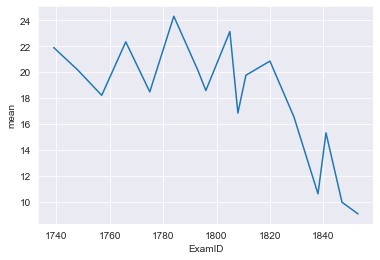

In [41]:
proveEmWrong = Grouped_By_Exam_ID['Score'].describe()
proveEmWrong['isOnline']=[0,1,0,1,0,1,1,0,1,1,1,1,0,1,0,0,0]
sns.lineplot(data = proveEmWrong, x= "ExamID",y="mean").figure.savefig("PerfForProvingEmWrong.pdf")

I Failed!

Let's take a trip to what ChatGPT suggested:

In [24]:
# Pivot the data so that each row represents a unique student and each column represents a unique exam
pivot_data = df.pivot(index='UserID', columns='ExamID', values='Taraz')

# Replace NaN values with the mean score for each exam
pivot_data.fillna(pivot_data.mean(), inplace=True)

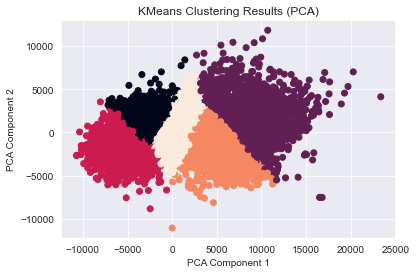

In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Fit a KMeans clustering model to the data
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(pivot_data)

# Apply PCA to reduce the dimensionality of the data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pivot_data)

# Plot the data with different colors for each cluster
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Results (PCA)')
plt.savefig("Clustering.pdf")


<AxesSubplot:xlabel='ExamID'>

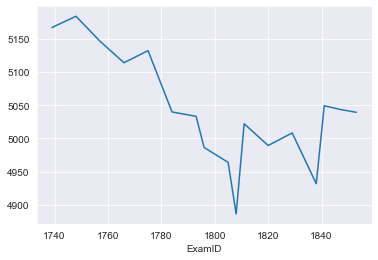

In [172]:
cluster_data = pivot_data[pivot_data['Cluster'] == 4].drop(columns= ['Cluster'])
mean_scores = cluster_data.mean()
mean_scores.plot()

Yeah That's it.

In [26]:
TarazDescription= Grouped_By_Exam_ID['Taraz'].describe()
StudentTarazDescription = Grouped_By_Student['Taraz'].describe()

In [27]:
# loop through the groups and calculate the slope of the linear regression for each group
linregresses = []
for name, group in Grouped_By_Student:
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['ExamID'], group['Taraz'])
    linregresses.append(slope)

StudentTarazDescription['linregresses'] = linregresses

/Users/arminnoqteh/miniconda3/envs/myenv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/arminnoqteh/miniconda3/envs/myenv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/arminnoqteh/miniconda3/envs/myenv/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [28]:
StudentTarazDescription= StudentTarazDescription.loc[StudentTarazDescription['count']!=1]

In [29]:
StudentTarazDescription['TarazClass'] = np.select([StudentTarazDescription['mean']>9000,StudentTarazDescription['mean']<=3000,StudentTarazDescription['mean'].between(3000.00001,4500),StudentTarazDescription['mean'].between(4500.00001,6000),StudentTarazDescription['mean'].between(6000.00001,9000)],["A","E","D","C","B"])
StudentTarazDescription.value_counts("TarazClass")

TarazClass
D    9137
C    7667
B    7104
E    3816
A     355
dtype: int64

In [30]:
StudentTarazDescription['AttendanceClass'] = np.select([StudentTarazDescription['count']<5,StudentTarazDescription['count'].between(5,11),StudentTarazDescription['count']>11],["Low","Normal","High"])
StudentTarazDescription.value_counts("AttendanceClass")

AttendanceClass
Normal    14196
Low        8471
High       5412
dtype: int64

In [31]:
StudentCat = StudentTarazDescription.iloc[:,[9,10]].reset_index()
UserExamID_Taraz = df.iloc[:,[0,1,3]]

In [32]:
StudentCat_UserExamID_Taraz = pd.merge(StudentCat,UserExamID_Taraz,on='UserID', how = 'inner')

In [33]:
pd.crosstab(index = StudentTarazDescription['TarazClass'],columns= StudentTarazDescription['AttendanceClass'])

AttendanceClass,High,Low,Normal
TarazClass,,,
A,61,146,148
B,1632,1647,3825
C,1685,1934,4048
D,1638,3001,4498
E,396,1743,1677


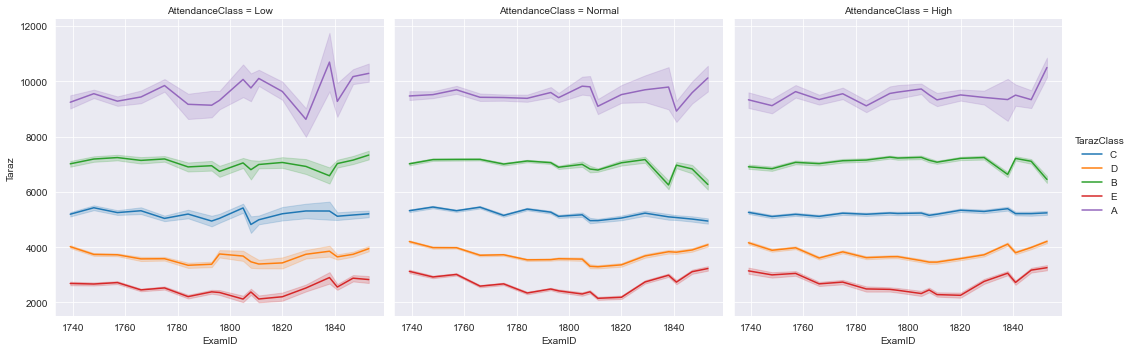

In [37]:
sns.relplot(
    data=StudentCat_UserExamID_Taraz, kind="line",
    x="ExamID", y="Taraz", col = "AttendanceClass",
    hue="TarazClass"
).savefig('Taraz-AttendanceClassV2.pdf')

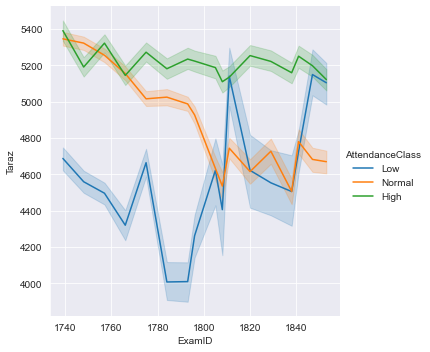

In [40]:
sns.relplot(
    data=StudentCat_UserExamID_Taraz, kind="line",
    x="ExamID", y="Taraz",
    hue="AttendanceClass"
).savefig("AttendanceClassV2.pdf")

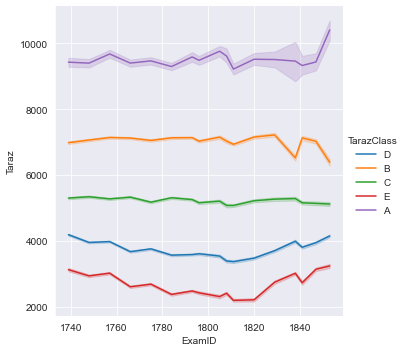

In [35]:
sns.relplot(
    data=StudentCat_UserExamID_Taraz.loc[StudentCat_UserExamID_Taraz['AttendanceClass']!="Low",:], kind="line",
    x="ExamID", y="Taraz",
    hue="TarazClass"
)

In [100]:
firstExam = 1739
secondExam = 1775
TwoExams = df[df['ExamID'].isin({firstExam,secondExam})]
TwoExams_pivot = TwoExams.pivot(index='UserID', columns='ExamID', values='Taraz').dropna()
TwoExams_pivot.describe()
# Categorize students based on their average score
labels = ['Poor', 'Below Average', 'Average', 'Above Average', 'Excellent']
TwoExams_pivot['Taraz Category First Exam'] = pd.qcut(TwoExams_pivot[firstExam], 5, labels=labels)
TwoExams_pivot['Taraz Category Second Exam'] = pd.qcut(TwoExams_pivot[secondExam], 5, labels=labels)

         count         mean          std     min      25%     50%      75%  \
ExamID                                                                       
1739    2300.0  6035.824783  1422.559742  1494.0  5238.75  6211.5  7004.25   
1775    2300.0  6315.329565   361.226758  5695.0  6001.00  6313.0  6617.25   

            max  
ExamID           
1739    10325.0  
1775     6967.0  


<AxesSubplot:xlabel='ExamID', ylabel='mean'>

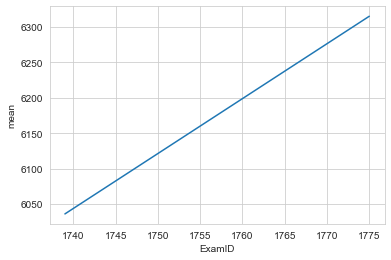

In [122]:
ForPlot = TwoExams_pivot.loc[TwoExams_pivot['Taraz Category Second Exam']=="Above Average"].describe().transpose()
print(ForPlot)
sns.lineplot(data = ForPlot,x="ExamID",y="mean")